Anomaly Detection in Network Traffic Using Unsupervised Learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
df = pd.read_csv("C:/Anomaly Detection in Network Traffic/corrected.gz", compression='gzip', header=None)
columns = pd.read_csv("C:/Anomaly Detection in Network Traffic/kddcup.names", skiprows=1, header=None)
columns = columns[0].apply(lambda x: x.split(":")[0]).tolist() + ['target']
df.columns = columns

categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col in categorical_cols:
    df[col] = encoders[col].transform(df[col])
X = df.drop("target", axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df["target"].apply(lambda x: 0 if x == 'normal.' else 1)


Isolation Forest

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_scaled)
preds_if = iso_forest.predict(X_scaled)
preds_binary = [0 if p == 1 else 1 for p in preds_if]
print(classification_report(y, preds_binary))


              precision    recall  f1-score   support

           0       0.20      0.92      0.33     60593
           1       0.84      0.10      0.19    250436

    accuracy                           0.26    311029
   macro avg       0.52      0.51      0.26    311029
weighted avg       0.71      0.26      0.21    311029



Auto Encoders for Anomaly Detection

In [13]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
input_dim = X_scaled.shape[1]
encoding_dim = 20
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

X_normal = X_scaled[y == 0]
autoencoder.fit(X_normal, X_normal, epochs=10, batch_size=256, shuffle=True, validation_split=0.1)
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
threshold = np.percentile(mse[y == 0], 95)
preds_ae = (mse > threshold).astype(int)
print("Autoencoder Results:")
print(classification_report(y, preds_ae, target_names=["Normal", "Attack"]))


Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1393 - val_loss: 0.0129
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_loss: 0.0083
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - val_loss: 0.0065
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
9720/9720 ━━━━━━━━━━━━━━━━━━━━ 6s 590us/step
Autoencoder Results:
              precision    recall  f1-score   support

      Normal      

Visualization

C:\Users\sanni\AppData\Local\Temp\ipykernel_11588\3466967674.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


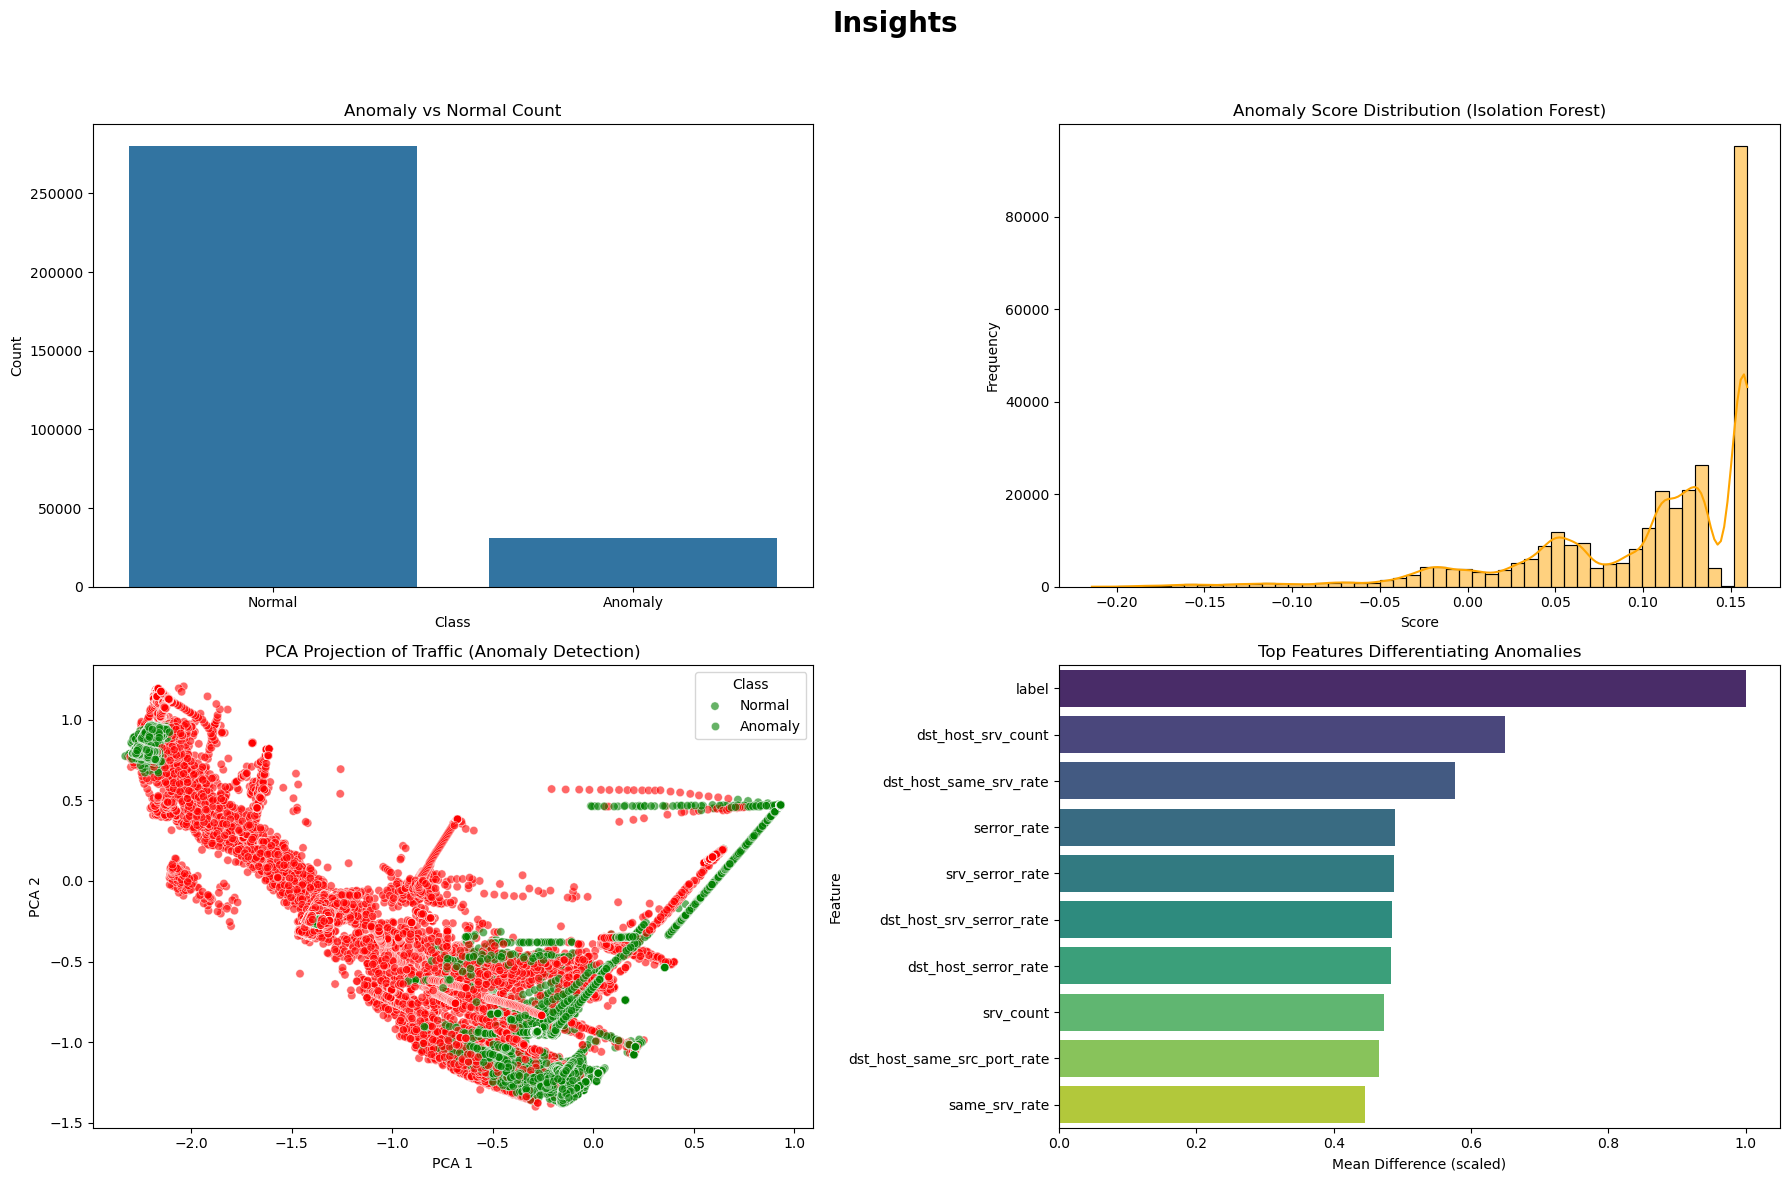

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

preds_binary = np.where(preds_if == -1, 1, 0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['label'] = preds_binary
mean_anomalies = df_scaled[df_scaled['label'] == 1].mean()
mean_normal = df_scaled[df_scaled['label'] == 0].mean()
diff = (mean_anomalies - mean_normal).abs().sort_values(ascending=False)
top_features = diff.head(10)
scores = iso_forest.decision_function(X_scaled)  # Lower = more anomalous
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
sns.countplot(x=pd.Series(preds_binary).map({0: "Normal", 1: "Anomaly"}))
plt.title("Anomaly vs Normal Count")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
sns.histplot(scores, bins=50, kde=True, color="orange")
plt.title("Anomaly Score Distribution (Isolation Forest)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.subplot(2, 2, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=preds_binary, palette=["green", "red"], alpha=0.6)
plt.title("PCA Projection of Traffic (Anomaly Detection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Class", labels=["Normal", "Anomaly"])
plt.subplot(2, 2, 4)
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top Features Differentiating Anomalies")
plt.xlabel("Mean Difference (scaled)")
plt.ylabel("Feature")

plt.suptitle("Insights", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


